# Synthetic Example

This notebook includes independent scripts for training a neural bias potential with GFlownets and evaluating the realisticity and diversity of our model on a synthetic system.

### Imports

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

### System Configuration


In [2]:
seed = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "results"

### Model Configuration

In [3]:
force = False
dist_feat = True

### Sampling Configuration

In [4]:
sigma = 1
num_steps = 1000
timestep = 0.01
num_samples = 512
temperature = 1200
kB = 8.6173303e-5 
kbT = kB * temperature
std = np.sqrt(2 * kbT * timestep)
normal = torch.distributions.Normal(0, std)
start_position = torch.tensor([-1.118, 0], dtype=torch.float32).to(device)
target_position = torch.tensor([1.118, 0], dtype=torch.float32).to(device)

### Training Configuration


In [5]:
log_z_lr = 0.01
policy_lr = 0.001
batch_size = 1024
num_rollouts = 1000
buffer_size = 50000
trains_per_rollout = 100
start_temperature = 4800
# start_temperature = 1200
end_temperature = 1200
kbTs = (
    torch.linspace(start_temperature, end_temperature, num_rollouts) * kB
)
train_stds = torch.sqrt(2 * kbTs * timestep)

### Synthetic System

In [6]:
def system(pos):
    pos.requires_grad_(True)
    x = pos[:, 0]
    y = pos[:, 1]
    term_1 = 4 * (1 - x**2 - y**2) ** 2
    term_2 = 2 * (x**2 - 2) ** 2
    term_3 = ((x + y) ** 2 - 1) ** 2
    term_4 = ((x - y) ** 2 - 1) ** 2
    potential = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0
    force = -torch.autograd.grad(potential.sum(), pos)[0]
    return potential, force

### Neural Bias Potential

In [7]:
class NeuralBias(nn.Module):
    def __init__(self):
        super().__init__()

        if force:
            self.output_dim = 2
        else:
            self.output_dim = 1

        if dist_feat:
            self.input_dim = 3
        else:  
            self.input_dim = 2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, self.output_dim, bias=False),
        )

        self.log_z = nn.Parameter(torch.tensor(0.0))

        self.to(device)

    def forward(self, pos):
        if not force:
            pos.requires_grad = True
        if dist_feat:
            dist = torch.norm(pos - target_position, dim=-1, keepdim=True)
            pos_ = torch.cat([pos, dist], dim=-1)
        else:
            pos_ = pos

        out = self.mlp(pos_.reshape(-1, self.input_dim))

        if not force:
            f = -torch.autograd.grad(
                out.sum(), pos, create_graph=True, retain_graph=True
            )[0]
        else:
            f = out.view(*pos.shape)

        return f

### TPS-GFN

In [8]:
class FlowNetAgent:
    def __init__(self):
        self.policy = NeuralBias()
        self.replay = ReplayBuffer()

    def sample(self, std, training=True):
        positions = torch.zeros(
            (num_samples, num_steps + 1, 2),
            device=device,
        )
        actions = torch.zeros(
            (num_samples, num_steps, 2),
            device=device,
        )
        noises = torch.normal(
            torch.zeros(
                (num_samples, num_steps, 2),
                device=device,
            ),
            torch.ones(
                (num_samples, num_steps, 2),
                device=device,
            ),
        )
        potentials = torch.zeros((num_samples, num_steps + 1), device=device)

        potential = system(start_position.unsqueeze(0))[0]

        position = start_position.unsqueeze(0)
        positions[:, 0] = position
        potentials[:, 0] = potential


        for s in range(num_steps):
            noise = noises[:, s]
            bias = self.policy(position.detach()).squeeze().detach()
            # bias = torch.zeros_like(noise)
            potential, force = system(position)
            mean = position + force * timestep
            position = position + (force + bias) * timestep + std * noise
            positions[:, s + 1] = position
            potentials[:, s + 1] = potential
            actions[:, s] = position - mean

        log_md_reward = normal.log_prob(actions.detach())
        log_target_reward = (
            -0.5
            * torch.square((positions - target_position.view(1, 1, -1)) / std).mean(2)
            / sigma
        )
        log_target_reward, last_idx = log_target_reward.max(1)
        log_reward = log_md_reward.mean((1, 2)) + log_target_reward

        if training:
            self.replay.add((positions.detach(), actions.detach(), log_reward.detach()))

        log = {
            "positions": positions,
            "potentials": potentials,
            "log_likelihood": log_md_reward.sum(-1).mean(1),
            "last_idx": last_idx,
        }
        return log

    def train(self):
        optimizer = torch.optim.Adam(
            [
                {"params": [self.policy.log_z], "lr": log_z_lr},
                {"params": self.policy.mlp.parameters(), "lr": policy_lr},
            ]
        )

        positions, actions, log_reward = self.replay.sample()

        biases = self.policy(positions[:, :-1].detach())

        log_z = self.policy.log_z
        log_forward = normal.log_prob(actions-biases).mean((1, 2))

        loss = (log_z + log_forward - log_reward).square().mean()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    
    
class ReplayBuffer:
    def __init__(self):
        self.positions = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.actions = torch.zeros(
            (buffer_size, num_steps, 2), device=device
        )
        self.log_reward = torch.zeros(buffer_size, device=device)

        self.idx = 0

    def add(self, data):
        indices = torch.arange(self.idx, self.idx + num_samples) % buffer_size
        self.idx += num_samples

        self.positions[indices], self.actions[indices], self.log_reward[indices] = data

    def sample(self):
        indices = torch.randperm(min(self.idx, buffer_size))[: num_samples]
        return self.positions[indices], self.actions[indices], self.log_reward[indices]

### Metrics and Plot

In [9]:
class Logger:
    def __init__(self):
        self.plot_samples = 64

    def log(self, positions, potentials, log_likelihood, last_idx):
        dist, dist_std = self.expected_distance(positions, last_idx)
        ll, ll_std = self.log_likelihood(log_likelihood)
        thp, etp, efp, etp_std, efp_std = self.cv_metrics(positions, potentials, last_idx)
        if thp > 0:
            print(f"Rollout: {rollout}, ED: {dist:.2f} (±{dist_std:.2f}), THP: {thp:.2f}, ETP: {etp:.2f} (±{etp_std:.2f}), LL: {ll:.2f} (±{ll_std:.2f}), EFP: {efp:.2f} (±{efp_std:.2f})")
        else:
            print(f"Rollout: {rollout}, ED: {dist:.2f} (±{dist_std:.2f}), THP: None, ETP: None, LL: {ll:.2f} (±{ll_std:.2f}), EFP: None")

    def expected_distance(self, positions, last_idx):
        last_position = positions[torch.arange(len(positions)), last_idx]
        dists = (last_position - target_position.unsqueeze(0)).square().mean((1))
        return dists.mean().item(), dists.std().item()

    def cv_metrics(self, positions, potentials, last_idx):
        etps, efps, etp_idxs, efp_idxs = [], [], [], []
        last_position = positions[torch.arange(len(positions)), last_idx]
        hits = (last_position - target_position.unsqueeze(0)).square().sum(1).sqrt() < 0.5

        for i, hit_idx in enumerate(hits):
            if hit_idx:
                etp, idx = potentials[i][: last_idx[i] + 1].max(0)
                etps.append(etp)
                etp_idxs.append(idx.item())

                efp = potentials[i][last_idx[i]]
                efps.append(efp)
                efp_idxs.append(last_idx[i].item())

        if len(etps) > 0:
            etps = torch.tensor(etps)
            efps = torch.tensor(efps)

            etp = etps.mean().item()
            efp = efps.mean().item()

            etp_std = etps.std().item()
            efp_std = efps.std().item()
        else:
            etp = None
            efp = None

            etp_std = None
            efp_std = None
            
        thp = 100 * hits.sum() / len(hits)
        return thp, etp, efp, etp_std, efp_std

    def log_likelihood(self, log_likelihood):
        return log_likelihood.mean().item(), log_likelihood.std().item()

    def plot_paths(self, save_dir, rollout, positions, last_idx):
        fig, ax = plt.subplots(figsize=(7, 7))
        positions = positions[:self.plot_samples].detach().cpu().numpy()
    
        z_num = 100
        circle_size = 1200
        saddle_size = 2400

        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        x = np.linspace(-1.5, 1.5, 400)
        y = np.linspace(-1.5, 1.5, 400)
        X, Y = np.meshgrid(x, y)
        
        term_1 = 4 * (1 - X**2 - Y**2) ** 2
        term_2 = 2 * (X**2 - 2) ** 2
        term_3 = ((X + Y) ** 2 - 1) ** 2
        term_4 = ((X - Y) ** 2 - 1) ** 2
        Z = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0
    
        ax.contourf(X, Y, Z, levels=z_num, zorder=0, vmax=3)
    
        ax.scatter([start_position[0].item()], [start_position[1].item()], 
                   edgecolors='black', c='w', zorder=z_num, s=circle_size)
        ax.scatter([target_position[0].item()], [target_position[1].item()], 
                   edgecolors='black', c='w', zorder=z_num, s=circle_size)
    
        saddle_points = [(0, 1), (0, -1)]
        for saddle in saddle_points:
            ax.scatter(saddle[0], saddle[1], edgecolors='black', c='w', 
                       zorder=z_num, s=saddle_size, marker="*")
    
        cm = plt.get_cmap('gist_rainbow')
        
        ax.set_prop_cycle(color=[cm(1. * i / len(positions)) for i in range(len(positions))])
        
        for i in range(len(positions)):
            ax.plot(positions[i, :last_idx[i], 0], positions[i, :last_idx[i], 1], 
                    marker='o', linestyle='None', markersize=2, alpha=1., zorder=z_num-1)
    
        ax.set_xlabel('x', fontsize=24, fontweight='medium')
        ax.set_ylabel('y', fontsize=24, fontweight='medium')
        ax.tick_params(left=False, right=False, labelleft=False, 
                       labelbottom=False, bottom=False)
        plt.tight_layout()
    
        plt.savefig(f"{rollout}.png")
        plt.show()
        plt.close()
        
        return fig

### Training

Rollout: 0, ED: 0.49 (±0.48), THP: 42.19, ETP: 2.62 (±0.63), LL: 0.35 (±0.12), EFP: 0.02 (±0.12)


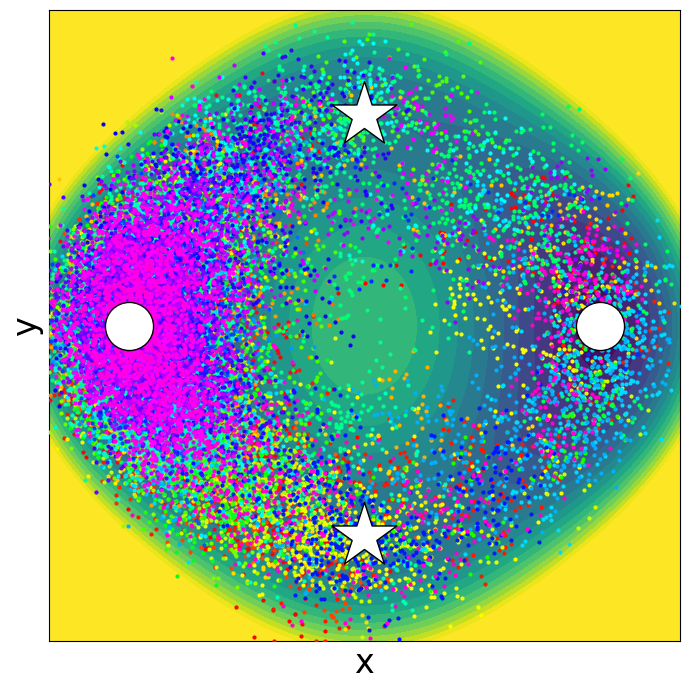

Rollout: 1, ED: 0.22 (±0.36), THP: 68.36, ETP: 2.54 (±0.62), LL: 0.35 (±0.12), EFP: 0.02 (±0.14)
Rollout: 2, ED: 0.21 (±0.35), THP: 68.36, ETP: 2.50 (±0.60), LL: 0.34 (±0.13), EFP: 0.03 (±0.15)
Rollout: 3, ED: 0.20 (±0.33), THP: 69.92, ETP: 2.49 (±0.65), LL: 0.35 (±0.13), EFP: 0.03 (±0.16)
Rollout: 4, ED: 0.20 (±0.34), THP: 69.53, ETP: 2.53 (±0.61), LL: 0.35 (±0.12), EFP: 0.02 (±0.14)
Rollout: 5, ED: 0.22 (±0.35), THP: 67.58, ETP: 2.47 (±0.59), LL: 0.36 (±0.13), EFP: 0.02 (±0.14)
Rollout: 6, ED: 0.21 (±0.34), THP: 67.38, ETP: 2.54 (±0.64), LL: 0.36 (±0.12), EFP: 0.01 (±0.12)
Rollout: 7, ED: 0.21 (±0.35), THP: 68.36, ETP: 2.53 (±0.65), LL: 0.37 (±0.12), EFP: 0.01 (±0.13)
Rollout: 8, ED: 0.22 (±0.35), THP: 68.95, ETP: 2.55 (±0.60), LL: 0.35 (±0.12), EFP: 0.01 (±0.11)
Rollout: 9, ED: 0.19 (±0.33), THP: 69.14, ETP: 2.53 (±0.61), LL: 0.37 (±0.13), EFP: 0.03 (±0.16)
Rollout: 10, ED: 0.20 (±0.33), THP: 69.73, ETP: 2.52 (±0.63), LL: 0.37 (±0.12), EFP: 0.03 (±0.17)
Rollout: 11, ED: 0.21 (±0.34)

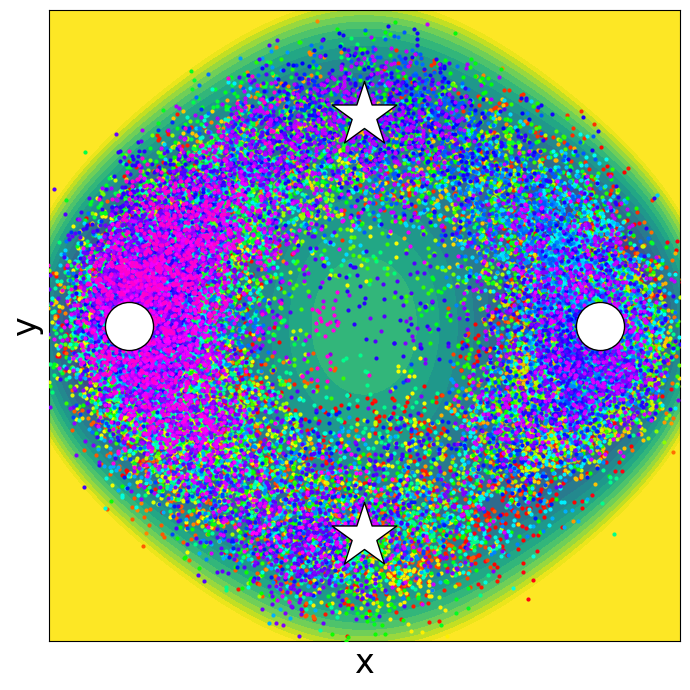

Rollout: 201, ED: 0.17 (±0.34), THP: 76.76, ETP: 2.29 (±0.49), LL: 0.93 (±0.11), EFP: 0.01 (±0.13)
Rollout: 202, ED: 0.18 (±0.34), THP: 75.59, ETP: 2.29 (±0.51), LL: 0.94 (±0.11), EFP: -0.01 (±0.09)
Rollout: 203, ED: 0.18 (±0.33), THP: 74.61, ETP: 2.26 (±0.51), LL: 0.95 (±0.11), EFP: 0.01 (±0.16)
Rollout: 204, ED: 0.19 (±0.35), THP: 72.66, ETP: 2.25 (±0.56), LL: 0.95 (±0.11), EFP: -0.00 (±0.10)
Rollout: 205, ED: 0.17 (±0.34), THP: 75.98, ETP: 2.29 (±0.54), LL: 0.95 (±0.11), EFP: -0.01 (±0.10)
Rollout: 206, ED: 0.16 (±0.33), THP: 77.34, ETP: 2.28 (±0.47), LL: 0.95 (±0.10), EFP: 0.00 (±0.10)
Rollout: 207, ED: 0.18 (±0.34), THP: 75.39, ETP: 2.30 (±0.50), LL: 0.95 (±0.11), EFP: -0.00 (±0.11)
Rollout: 208, ED: 0.17 (±0.33), THP: 75.59, ETP: 2.29 (±0.52), LL: 0.97 (±0.11), EFP: -0.00 (±0.11)
Rollout: 209, ED: 0.21 (±0.37), THP: 72.07, ETP: 2.25 (±0.47), LL: 0.96 (±0.11), EFP: 0.01 (±0.13)
Rollout: 210, ED: 0.19 (±0.36), THP: 75.39, ETP: 2.27 (±0.51), LL: 0.96 (±0.11), EFP: -0.00 (±0.10)
Roll

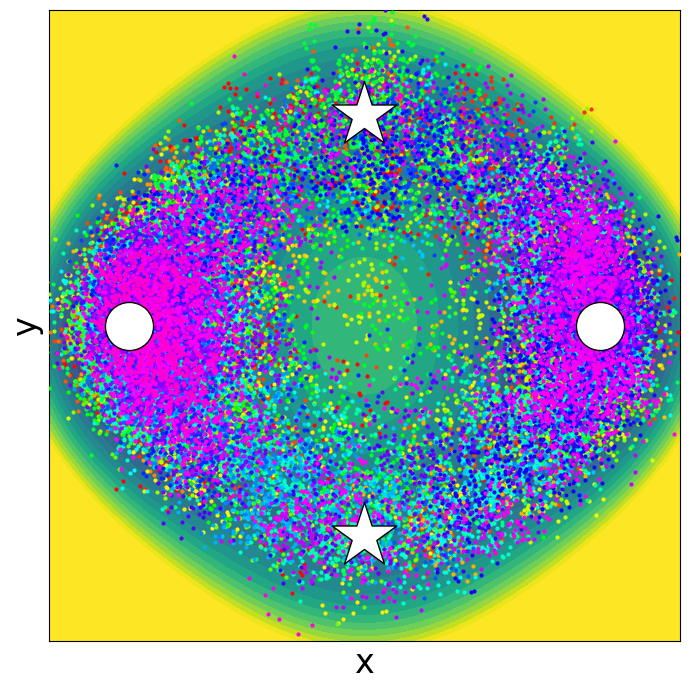

Rollout: 401, ED: 0.23 (±0.41), THP: 73.44, ETP: 1.98 (±0.36), LL: 1.53 (±0.09), EFP: -0.02 (±0.09)
Rollout: 402, ED: 0.21 (±0.40), THP: 74.41, ETP: 1.98 (±0.42), LL: 1.54 (±0.09), EFP: -0.01 (±0.09)
Rollout: 403, ED: 0.23 (±0.42), THP: 73.83, ETP: 1.96 (±0.37), LL: 1.53 (±0.09), EFP: -0.01 (±0.09)
Rollout: 404, ED: 0.20 (±0.38), THP: 76.76, ETP: 1.93 (±0.30), LL: 1.54 (±0.09), EFP: -0.01 (±0.09)
Rollout: 405, ED: 0.20 (±0.38), THP: 76.37, ETP: 1.96 (±0.39), LL: 1.54 (±0.09), EFP: -0.00 (±0.13)
Rollout: 406, ED: 0.22 (±0.41), THP: 75.00, ETP: 1.96 (±0.37), LL: 1.54 (±0.09), EFP: -0.02 (±0.09)
Rollout: 407, ED: 0.22 (±0.41), THP: 75.39, ETP: 1.96 (±0.40), LL: 1.55 (±0.08), EFP: -0.01 (±0.10)
Rollout: 408, ED: 0.19 (±0.38), THP: 77.73, ETP: 1.95 (±0.37), LL: 1.55 (±0.09), EFP: -0.02 (±0.08)
Rollout: 409, ED: 0.20 (±0.40), THP: 75.98, ETP: 1.98 (±0.37), LL: 1.55 (±0.09), EFP: -0.01 (±0.12)
Rollout: 410, ED: 0.27 (±0.45), THP: 70.51, ETP: 1.99 (±0.38), LL: 1.56 (±0.08), EFP: -0.01 (±0.10)


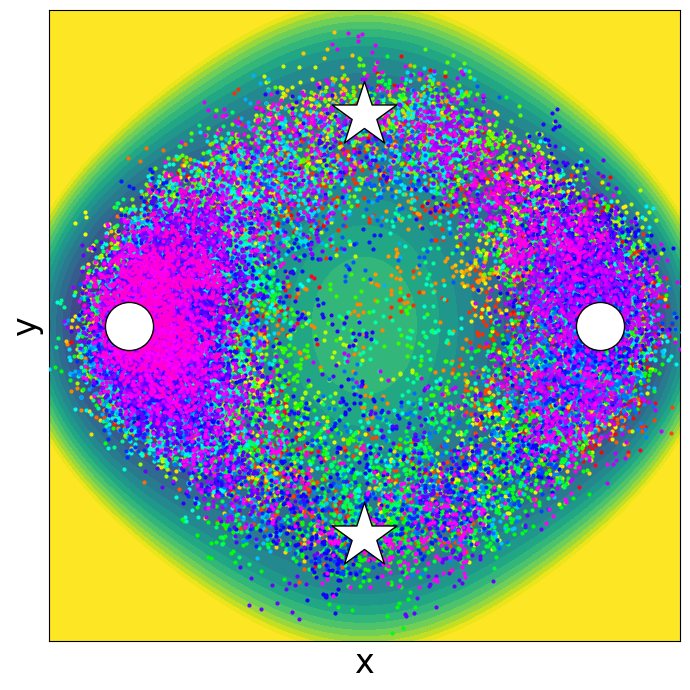

Rollout: 601, ED: 0.28 (±0.47), THP: 71.29, ETP: 1.76 (±0.25), LL: 2.12 (±0.07), EFP: -0.02 (±0.11)
Rollout: 602, ED: 0.31 (±0.48), THP: 67.77, ETP: 1.75 (±0.25), LL: 2.12 (±0.07), EFP: -0.02 (±0.10)
Rollout: 603, ED: 0.26 (±0.45), THP: 74.22, ETP: 1.74 (±0.27), LL: 2.13 (±0.07), EFP: -0.02 (±0.09)
Rollout: 604, ED: 0.29 (±0.48), THP: 71.09, ETP: 1.77 (±0.27), LL: 2.14 (±0.07), EFP: -0.03 (±0.08)
Rollout: 605, ED: 0.27 (±0.45), THP: 70.70, ETP: 1.75 (±0.29), LL: 2.14 (±0.07), EFP: -0.01 (±0.11)
Rollout: 606, ED: 0.30 (±0.47), THP: 67.97, ETP: 1.77 (±0.29), LL: 2.14 (±0.07), EFP: -0.03 (±0.08)
Rollout: 607, ED: 0.29 (±0.48), THP: 70.70, ETP: 1.77 (±0.26), LL: 2.15 (±0.07), EFP: -0.02 (±0.09)
Rollout: 608, ED: 0.29 (±0.47), THP: 70.31, ETP: 1.75 (±0.27), LL: 2.15 (±0.07), EFP: -0.02 (±0.09)
Rollout: 609, ED: 0.28 (±0.46), THP: 71.48, ETP: 1.76 (±0.27), LL: 2.15 (±0.07), EFP: -0.03 (±0.08)
Rollout: 610, ED: 0.30 (±0.48), THP: 68.75, ETP: 1.77 (±0.26), LL: 2.15 (±0.07), EFP: -0.03 (±0.08)


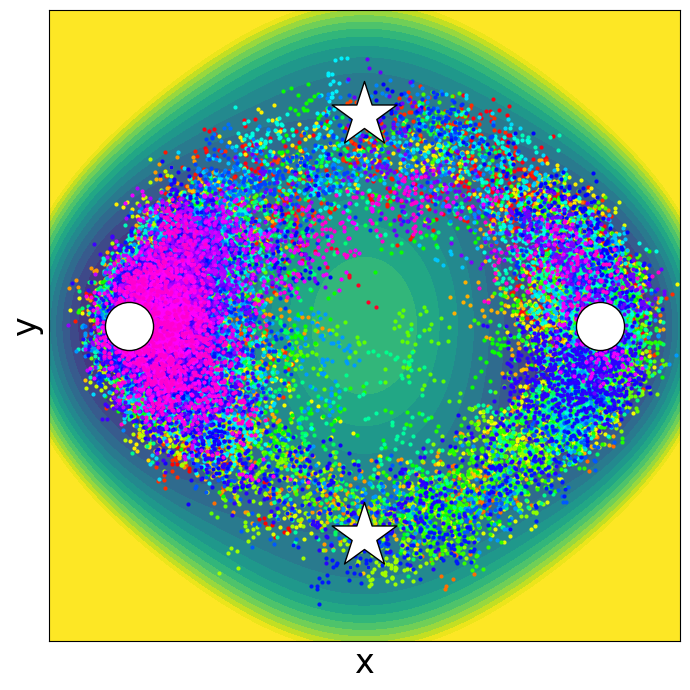

Rollout: 801, ED: 0.39 (±0.55), THP: 63.48, ETP: 1.58 (±0.23), LL: 2.72 (±0.05), EFP: -0.04 (±0.07)
Rollout: 802, ED: 0.41 (±0.56), THP: 61.52, ETP: 1.58 (±0.22), LL: 2.72 (±0.05), EFP: -0.04 (±0.07)
Rollout: 803, ED: 0.42 (±0.56), THP: 61.91, ETP: 1.57 (±0.22), LL: 2.73 (±0.05), EFP: -0.04 (±0.07)
Rollout: 804, ED: 0.38 (±0.55), THP: 64.65, ETP: 1.60 (±0.22), LL: 2.72 (±0.05), EFP: -0.04 (±0.07)
Rollout: 805, ED: 0.42 (±0.55), THP: 60.35, ETP: 1.57 (±0.22), LL: 2.73 (±0.05), EFP: -0.03 (±0.10)
Rollout: 806, ED: 0.40 (±0.56), THP: 64.65, ETP: 1.57 (±0.21), LL: 2.73 (±0.05), EFP: -0.03 (±0.09)
Rollout: 807, ED: 0.37 (±0.54), THP: 64.65, ETP: 1.57 (±0.22), LL: 2.74 (±0.05), EFP: -0.04 (±0.06)
Rollout: 808, ED: 0.40 (±0.55), THP: 63.87, ETP: 1.57 (±0.22), LL: 2.74 (±0.05), EFP: -0.03 (±0.08)
Rollout: 809, ED: 0.41 (±0.56), THP: 62.89, ETP: 1.58 (±0.21), LL: 2.74 (±0.05), EFP: -0.03 (±0.09)
Rollout: 810, ED: 0.42 (±0.57), THP: 62.50, ETP: 1.60 (±0.23), LL: 2.74 (±0.05), EFP: -0.03 (±0.08)


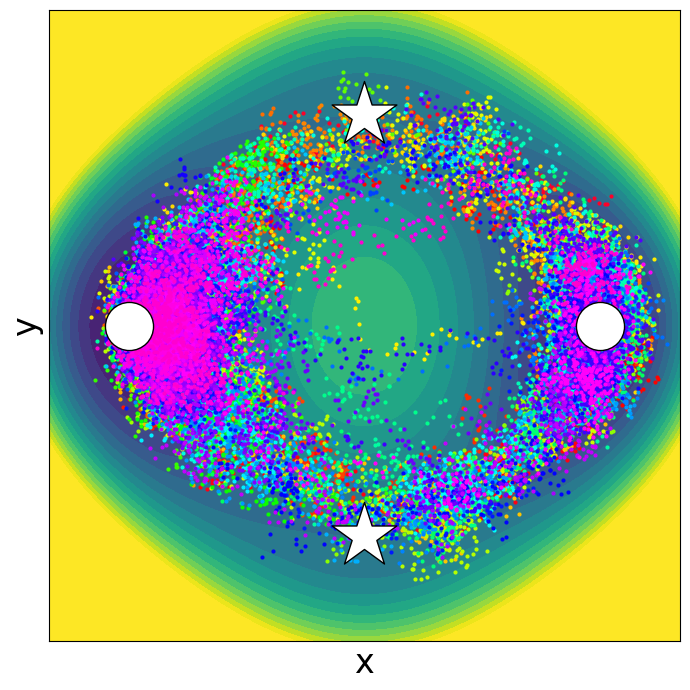

In [10]:
torch.manual_seed(seed)
agent = FlowNetAgent()
logger = Logger()

for rollout in range(num_rollouts):
    log = agent.sample(train_stds[rollout])
    logger.log(**log)

    for _ in range(trains_per_rollout):
        agent.train()
    
    if rollout%200 == 0 or rollout==num_rollouts-1:
        logger.plot_paths(save_dir, rollout, log["positions"], log["last_idx"])